In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

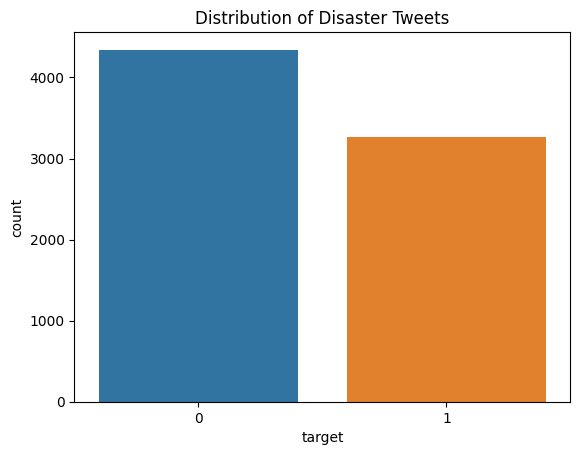

In [4]:
sns.countplot(x='target', data=df)
plt.title('Distribution of Disaster Tweets')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

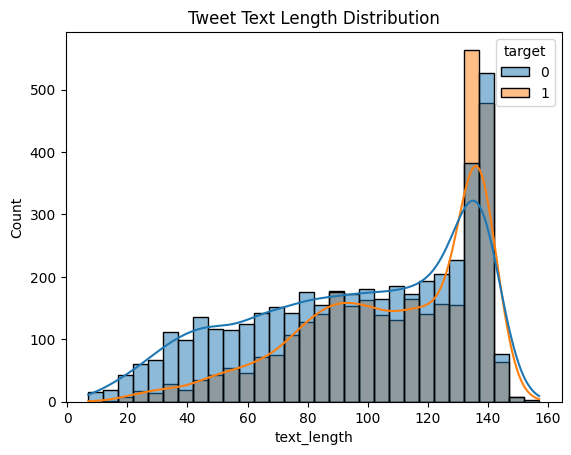

In [5]:
df['text_length'] = df['text'].apply(len)
sns.histplot(df, x='text_length', hue='target', bins=30, kde=True)
plt.title('Tweet Text Length Distribution')
plt.show()

In [6]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def plot_word_freq(corpus, title):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(' '.join(corpus).lower())
    words = [word for word in words if word.isalpha() and word not in stop_words]
    freq_dist = Counter(words)
    top_words = freq_dist.most_common(30)
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

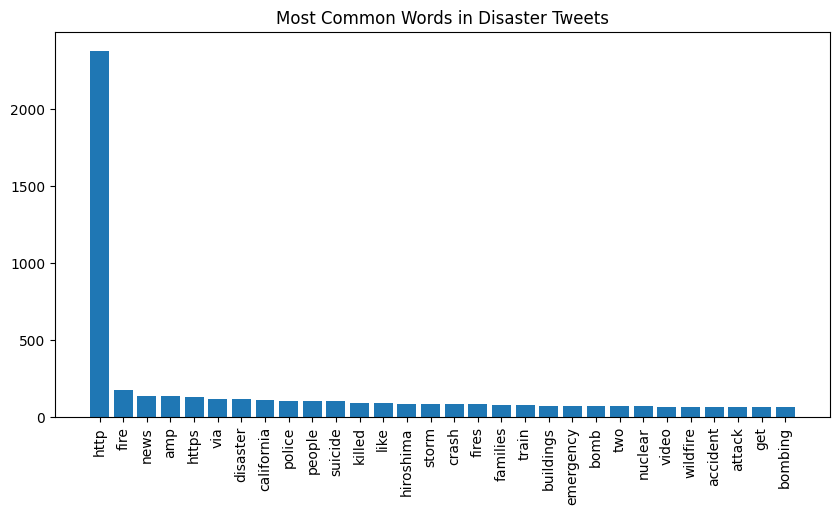

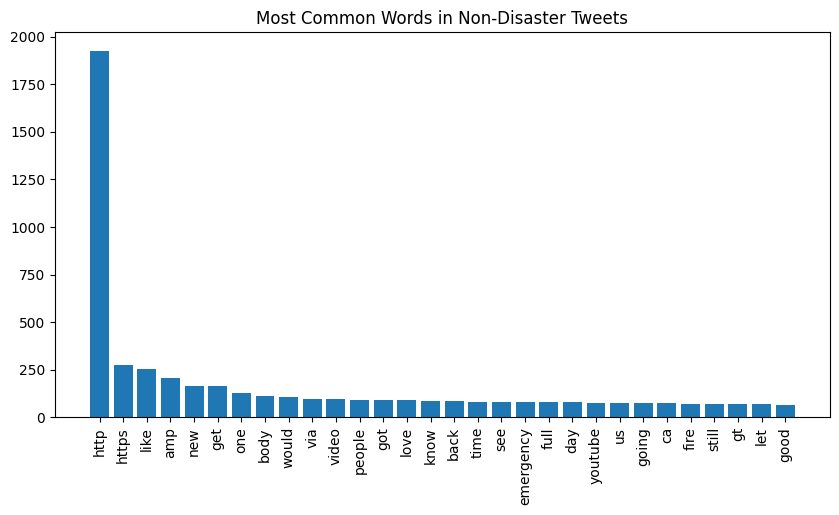

In [15]:
disaster_tweets = df[df['target'] == 1]['text']
non_disaster_tweets = df[df['target'] == 0]['text']
plot_word_freq(disaster_tweets, 'Most Common Words in Disaster Tweets')
plot_word_freq(non_disaster_tweets, 'Most Common Words in Non-Disaster Tweets')

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2024-02-19 05:31:00.671016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 05:31:00.671205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 05:31:00.842789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
max_sequence_len = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_sequence_len)
y = df['target'].values

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the minimum validation loss
)

In [20]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Adjusting the model architecture
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Adding more callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint, reduce_lr])


Epoch 1/10
191/191 [==============================] - 16s 61ms/step - loss: 0.5381 - accuracy: 0.7215 - val_loss: 0.4396 - val_accuracy: 0.8037 - lr: 0.0010
Epoch 2/10
  1/191 [..............................] - ETA: 8s - loss: 0.2714 - accuracy: 0.9062

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 10s 53ms/step - loss: 0.2717 - accuracy: 0.8931 - val_loss: 0.5098 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 3/10
191/191 [==============================] - 10s 54ms/step - loss: 0.0908 - accuracy: 0.9691 - val_loss: 0.6726 - val_accuracy: 0.7597 - lr: 0.0010
Epoch 4/10
191/191 [==============================] - 10s 51ms/step - loss: 0.0349 - accuracy: 0.9897 - val_loss: 0.8181 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 4: early stopping


In [12]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_len, embeddings_regularizer=l2(0.001)))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.5))
model.add(LSTM(32, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Assuming X_train, y_train, X_val, y_val are already defined
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/20
191/191 [==============================] - 19s 74ms/step - loss: 0.9205 - accuracy: 0.7190 - val_loss: 0.6014 - val_accuracy: 0.7951
Epoch 2/20
191/191 [==============================] - 12s 64ms/step - loss: 0.5322 - accuracy: 0.8351 - val_loss: 0.6299 - val_accuracy: 0.7814
Epoch 3/20
191/191 [==============================] - 12s 62ms/step - loss: 0.4499 - accuracy: 0.8862 - val_loss: 0.6603 - val_accuracy: 0.7827
Epoch 4/20
191/191 [==============================] - 12s 64ms/step - loss: 0.3851 - accuracy: 0.9217 - val_loss: 0.7476 - val_accuracy: 0.7557
Epoch 5/20
191/191 [==============================] - 12s 65ms/step - loss: 0.3339 - accuracy: 0.9350 - val_loss: 0.8231 - val_accuracy: 0.7380
Epoch 6/20
191/191 [==============================] - 12s 65ms/step - loss: 0.3376 - accuracy: 0.9414 - val_loss: 0.8354 - val_accuracy: 0.7584


In [13]:
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print("Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(test_loss, test_accuracy))

48/48 [==============================] - 1s 14ms/step - loss: 0.8354 - accuracy: 0.7584
Test Loss: 0.8354, Test Accuracy: 0.7584


In [14]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
texts = test['text'].tolist()

In [24]:
# Assuming the tokenizer and max_length are already defined as used in training
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post', truncating='post')

In [25]:
predictions = model.predict(padded_sequences)

102/102 [==============================] - 2s 11ms/step


In [29]:
len(predictions)

3263

In [26]:
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions.flatten()]

In [32]:
predictions_df = pd.DataFrame({'id': test['id'], 'target': binary_predictions})
predictions_df.to_csv('/kaggle/working/submission2.csv', index=False)